# What did the deep ocean ever to for us?

We wanted to find out. So we removed it.

This is based on the Earth System Box Model (ESBM) introduced in the IMPRS Intro Course 2022. The ESBM is designed to show how the earth system is pushed into a new equilibrium by a perturbation by anthropogenic emissions. Is consists of a set of six differential equations, two for energy and four for carbon budgets:

### original set of equations
$$
c_s\dot{T}_s = \beta  ln( \frac{C_a}{C_a^0} + 1 ) - \lambda  (T_s) - \lambda_*  (T_s - T_d)  - \eta_H  (T_s - T_d)
$$
$$
c_d\dot{T}_d = \eta_H  ( T_s - T_d )
$$
$$
\dot{C}_l = \Pi^0  \bigg[ (1 + \beta_\Pi  ln \big( \frac{C_a}{C_a^0} + 1 \big) \bigg] - \frac{C_l + C_l^0}{(\tau_l^0  \chi^( \frac{-T_s}{10} ) } 
$$
$$
\dot{C}_s = \gamma  \bigg( \frac{C_a}{k_a} - \frac{C_s}{k_o} \bigg) - \eta_C  \bigg( \frac{C_s}{\delta} - \frac{C_d}{1 - \delta} \bigg)
$$
$$
\dot{C}_d = \eta_C  \bigg( \frac{C_s}{\delta} - \frac{C_d}{1 - \delta} \bigg)
$$
$$
\dot{C}_a = \mathcal{J}(t) - \dot{C}_a - \dot{C}_s - \dot{C}_d
$$

We started off with the idea to implement everything in `sympy`. Therefore we ended upt with a set of functions, implementing the equations in `sympy`:

In [1]:
import sympy as sym

def sec2yr(s):
    return s * 60 * 60 * 24 * 365
def yr2sec(y):
    return y / (60 * 60 * 24 * 365)

# Sympy symbols 
# C_l, C_a, C_s, C_d, T_s = sym.symbols('C_l, C_a, C_s, C_d, T_s')
delta, eta_C = sym.symbols('\delta, \eta_C')
tau_l0, chi, C_l0, T_s = sym.symbols('\\tau_l^0 \chi C_l^0 T_s')
beta_P, beta, C_a0, preInd = sym.symbols('\\beta_{\Pi} \\beta \mathcal{C}_a^0 \Pi^0')
gam, k_a, k_o = sym.symbols('\gamma, \mathcal{k}_a \mathcal{k}_o')
A_tot, t_opt, t = sym.symbols('A_{tot}, t_{opt}, t')
eta_H = sym.Symbol('\eta_H')
lam, lam_st = sym.symbols('\lambda, \lambda_*')
delta, c_star = sym.symbols('\delta, c_*')

# values those symbols that are constants or parameters to be set
constants = {
    chi    : 1.8, # scaling factor for soil carbon lifetime decrease. empirically set to 1.8 (S
    tau_l0 : 41, # years 
    # C_l0   : 2500,  # GtCO2 (Sec 7.1)  
    C_l0   : 2460,  # GtCO2 tuned to get rid of initial exchange
    preInd : 60, # GtC/yr
    beta_P : 0.4, # co2 fertilisation factor
    # C_a0   : 37000 / 7, # GtC, estimate as 1/7 of ocean reservoir as given in paragraph 7.2
    C_a0   : 2.12 * 280,
    k_a    : 2.12, # GtC/ppm (page 41)
    # k_o    : 2.12 * (1-1/7)/(1/7) * 0.015,
    # k_o    : 2.12, # proposed by Victor
    k_o    : 2.0421, # also proposed by Victor via Mattermost, apparentyl the equation missed a Revelle factor
    gam    : 0.005, # GtC/year/ppm
    t_opt  : 250,  # years, time scale of emission
    A_tot  : 5000,  # GtC total emission
    # A_tot  : 100000,  # GtC total emission
    delta  : 0.015,  # Surface ocean fraction
    # eta_C  : 60e-12,  # [s^-1] Surface-deep ocean carbon exchange coefficient
    eta_C  : sec2yr(60e-12), # [yr^-1] Surface-deep ocean carbon exchange coefficient
    # eta_H  : 1, # enthalpy exchange coefficient
    eta_H  : 0.73, # enthalpy exchange coefficient, as proposed by Moritz
    beta   : 5.77, # W m-2 ; CO2 radiative forcing strength
    # lam    : 0.0, # W m-1 K-2 ; Radiative response to surface temperature anomaly
    lam    : 1.77, # W m-1 K-2 ; Radiative response to surface temperature anomaly
    # lam_st : 0, # W m-1 K-2 ; Radiative response to surface-deep ocean equilibrium, tunable parameter
    lam_st : 0.75, # W m-1 K-2 ; Radiative response to surface-deep ocean equilibrium, tunable parameter
    delta  : 0.015, # surface ocean fraction (of all ocean)
    # c_star : sec2yr(10.8e9), # J K-1 m-2 ; area specific heat of sea water
    c_star : yr2sec(108e8), # J K-1 m-2 ; area specific heat of sea water
}

def fetch_constants(symbol_set):
    # returns a subset of the global constants
    global constants
    c = dict()
    for s in symbol_set:
        c[s] = constants[s]
    return c


def radiation_term():
    T_s, T_d, C_a, cap = sym.symbols('T_s, T_d, C_a, c') 
    global lam, lam_st, beta, C_a0, k_a
    constants = fetch_constants([lam, lam_st, beta, C_a0, k_a])
    expr = (- (lam * (T_s)) - (lam_st * (T_s - T_d)) + (beta * sym.log( C_a / C_a0 + 1 ))) / cap
    return sym.lambdify((T_s, T_d, C_a, cap), expr.subs(constants))

def radiation_term_no_deep():
    T_s, T_d, C_a, cap = sym.symbols('T_s, T_d, C_a, c') 
    global lam, lam_st, beta, C_a0, k_a
    constants = fetch_constants([lam, lam_st, beta, C_a0, k_a])
    expr = ((beta * sym.log( C_a / C_a0 + 1 )) - (lam * (T_s)) ) / cap
    return sym.lambdify((T_s, C_a, cap), expr.subs(constants))

# this performs thermal conduction between two layers (Eq. 6.14), also used as part of Eq. 6.13
def enthalpy_exchange():
    T_s, T_d, cap = sym.symbols('T_s, T_d, c') 
    global eta_H
    constants = fetch_constants([eta_H])
    expr = eta_H * (T_s - T_d) / cap
    return sym.lambdify((T_s, T_d, cap), expr.subs(constants))

def carbon_flux_surface_deep():
    # carbon flux between the surface and deep ocean (C_d)
    C_s, C_d = sym.symbols('C_s, C_d') 
    global delta, eta_C
    constants = fetch_constants([delta, eta_C])
    expr = eta_C * (C_s / delta - C_d / (1 - delta)) # Eq. 7.11 / 8.5
    return sym.lambdify((C_s, C_d), expr.subs(constants))

def land_carbon_uptake():
    # Heterotrophic (soil) respiration (Eq. 7.5)
    C_l, C_a, T_s = sym.symbols('C_l, C_a, T_s') # as by model design: T_s == T_l
    global tau_l0, chi, C_l0
    Rh_constants = fetch_constants([tau_l0, chi, C_l0])
    Rh_expr = (C_l + C_l0)/(tau_l0 * chi **( -T_s / 10 ))
    # global net primary productivity (Eq. 7.4)
    global beta_P, C_a0, preInd
    P_constants = fetch_constants([beta_P, C_a0, preInd])
    P_expr = preInd * (1 + beta_P * sym.ln(C_a/C_a0 + 1))
    # unified function is land carbon uptake flux (Eq. 7.3) 
    return sym.lambdify((C_l,C_a,T_s), (P_expr - Rh_expr).subs(P_constants | Rh_constants))

def land_carbon_uptake_vari_beta_chi():
    # a version of the function above, that does not assume constant values for beta_P and chi
    # Heterotrophic (soil) respiration (Eq. 7.5)
    C_l, C_a, T_s = sym.symbols('C_l, C_a, T_s') # as by model design: T_s == T_l
    global tau_l0, chi, C_l0
    Rh_constants = fetch_constants([tau_l0, C_l0])
    Rh_expr = (C_l + C_l0)/(tau_l0 * chi **( -T_s / 10 ))
    # global net primary productivity (Eq. 7.4)
    global beta_P, C_a0, preInd
    P_constants = fetch_constants([C_a0, preInd])
    P_expr = preInd * (1 + beta_P * sym.ln(C_a/C_a0 + 1))
    # unified function is land carbon uptake flux (Eq. 7.3) 
    return sym.lambdify((C_l,C_a,T_s,beta_P,chi), (P_expr - Rh_expr).subs(P_constants | Rh_constants))

def atmosphere_ocean_exchange():
    # model of atmosphere ocean exchange of CO2 J_{a-s} (Eq. 7.9)
    C_a, C_s = sym.symbols('C_a, C_s') 
    global gam, k_a, k_o
    constants = fetch_constants([gam, k_a, k_o])
    expr = gam * ((C_a/k_a) - (C_s/k_o))
    return sym.lambdify((C_a, C_s), expr.subs(constants))

def gammavar_atmosphere_ocean_exchange(gamma):
    # model of atmosphere ocean exchange of CO2 J_{a-s} (Eq. 7.9)
    C_a, C_s = sym.symbols('C_a, C_s') 
    global gam, k_a, k_o
    constants = fetch_constants([gam, k_a, k_o])
    # victor suggested, that the surface ocean - amtmosphere coupling is too sluggish
    # so i play around a little:
    constants[gam] = gamma

    expr = gam * ((C_a/k_a) - (C_s/k_o))
    return sym.lambdify((C_a, C_s), expr.subs(constants))

def anthropogenic_emission():
    # Anthropogenic emissions (A(t)), Eq. (7.17)
    t = sym.Symbol('t')
    global A_tot, t_opt
    constants = fetch_constants([A_tot, t_opt])
    expr = A_tot * ((1 / (1 + 2.5 * sym.exp((t_opt - t)/50))) - (1 / (1 + 2.5 * sym.exp(t_opt / 50))))
    expr_dt = sym.Derivative(expr,t).doit()
    return sym.lambdify((t), expr_dt.subs(constants))

def instantaneous_emission():
    def insta(t):
        if t == 1:
            return constants[A_tot]
        else:
            return 0
    return insta

## The invisible code
We created a class to make the interaction with the model more intuitive. Is the class really is better than the ODE solver alternative (shown at the bottom of this notebook)? I don't know. I like it better.

In [179]:
import matplotlib.pyplot as plt
import numpy as np

# This class is at the heart of our model
from boxmodel import BoxModel

# Adding another plotting option:
# temperature and carbon time series side by side
def maria_plot(model, full=False, xlim=None, ylim=None, title=None, printkeys=False):
    if printkeys: print(model.output.keys())
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    if title: fig.suptitle(title)
    ax = axs[1]
    x = model.output['time']
    y = model.output['land_C']
    ax.plot(x, y, color='green', label=f'Land (last: {y[-1]:.0f} Gt)')
    y = model.output['surface ocean_C']
    ax.plot(x, y, color='lightblue', label=f'Surface ocean (last: {y[-1]:.0f} Gt)')
    if full:
        y = model.output['deep ocean_C']
        ax.plot(x, y, color='darkblue', label=f'Deep ocean (last: {y[-1]:.0f} Gt)')
    y = model.output['atmosphere_C']
    ax.plot(x, y, color='red', label=f'Atmosphere (last: {y[-1]:.0f} Gt)')
    ax.set_xlabel('time [years]')
    ax.set_ylabel('$\Delta$ C [GtC]')
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    ax.legend()
    
    ax = axs[0]
    y = model.output['surface ocean_T']
    ax.plot(x, y, color='lightblue', label=f'Surface ocean \n(max:{np.max(y):.2f} K, last: {y[-1]:.0f} K)')
    if full:
        y = model.output['deep ocean_T']
        ax.plot(x, y, color='darkblue', label=f'Deep ocean \n(max:{np.max(y):.2f} K, last: {y[-1]:.0f} K)')
    ax.set_xlabel('time [years]')
    ax.set_ylabel('$\Delta$ T [K]')
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    ax.legend()
    
    return fig, axs

## Original scenario

Using the `BoxModel` class and the function defined above we set up the model in its original form: A coupled earth system box model with an emission scenario that emits 5000 Gt Carbon over a period of under 500 years (`anthropogenic_emission()`). The plot shows how the system equilibrates after this perturbance: The deep ocean with its vast reservoir takes up most of the carbon over the long term.  Atmosphere, surface ocean and land biosphere respond quicker and take up, which mostly ends up in the deep ocean after a couple of centuries.

dict_keys(['step', 'time', 'deep ocean_C', 'deep ocean_T', 'deep ocean_c', 'surface ocean_C', 'surface ocean_T', 'surface ocean_c', 'atmosphere_C', 'land_C'])


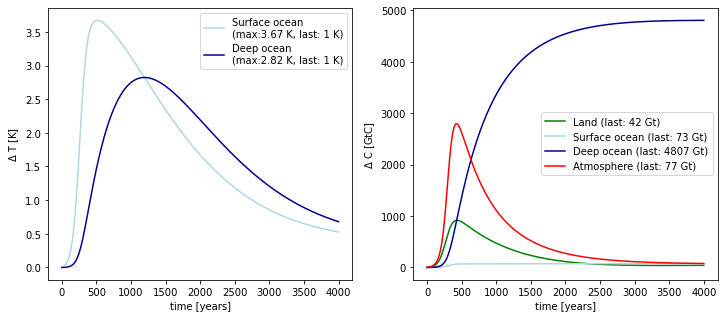

In [5]:
coupled = BoxModel(step=(4000,1))
model = coupled
model.add_box('deep ocean',    {'C':0.0, 'T': 0.0, 'c':(1 - constants[delta]) * constants[c_star]})
model.add_box('surface ocean', {'C':0.0, 'T': 0.0, 'c':constants[delta]      * constants[c_star]})
model.add_box('atmosphere',    {'C':0.0} )
model.add_box('land', {'C':0.0 } )

model.boxes['deep ocean'].add_process('ocean circulation', 'T', enthalpy_exchange(), 
                                           [ model.boxes['surface ocean'].attr['T'], 
                                             model.boxes['deep ocean'].attr['T'],
                                             model.boxes['deep ocean'].attr['c']
                                           ], sign='+')
model.boxes['surface ocean'].add_process('ocean circulation', 'T', enthalpy_exchange(), 
                                           [ model.boxes['surface ocean'].attr['T'], 
                                             model.boxes['deep ocean'].attr['T'],
                                             model.boxes['surface ocean'].attr['c']
                                           ], sign='-')
model.boxes['deep ocean'].add_process('carbon flux', 'C', carbon_flux_surface_deep(), 
                                           [ model.ref('surface ocean_C'),
                                             model.ref('deep ocean_C')
                                           ], sign='+')
model.boxes['surface ocean'].add_process('carbon flux', 'C', carbon_flux_surface_deep(), 
                                           [ model.ref('surface ocean_C'),
                                             model.ref('deep ocean_C')
                                           ], sign='-')
model.boxes['surface ocean'].add_process('radiation', 'T', radiation_term(), 
                                           [ model.ref('surface ocean_T'), 
                                             model.ref('deep ocean_T'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_c')
                                           ])
model.boxes['surface ocean'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='-')
model.boxes['atmosphere'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='-')
model.boxes['land'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('emission', 'C', anthropogenic_emission(), 
                                           [ model.current_time,
                                           ], sign='+')
model.run()
fig, axs = maria_plot(model, full=True)

## So Long, and Thanks for All the Fish

This model is already fairly simple. But nothing is safe from our need for simplicity. So to improve it's Zen we decided to get rid of a component. The less interconected Box is the deep ocean, which only interacts with the surface ocean. So we removed the deep ocean. 

We removed all equations (=processes), that involve the deep ocean. This includes the ocean circulation term $ \eta_H  (T_s - T_d)$, the assymetry albedo term $ \lambda_*  (T_s - T_d) $ and the carbon mixing  $ \eta_C  \bigg( \frac{C_s}{\delta} - \frac{C_d}{1 - \delta} \bigg) $ and removed $  \dot{C}_d $ from the sum. This leaves us with the following set of equations as an description of the model: 

$$
c_s\dot{T}_s = \beta  ln( \frac{C_a}{C_a^0} + 1 ) - \lambda  (T_s)
$$
$$
\dot{C}_l = \Pi^0  \bigg[ (1 + \beta_\Pi  ln \big( \frac{C_a}{C_a^0} + 1 \big) \bigg] - \frac{C_l + C_l^0}{(\tau_l^0  \chi^( \frac{-T_s}{10} ) } 
$$
$$
\dot{C}_s = \gamma  \bigg( \frac{C_a}{k_a} - \frac{C_s}{k_o} \bigg)
$$
$$
\dot{C}_a = \mathcal{J}(t) - \dot{C}_a - \dot{C}_s
$$

What behaviour would we expect from this changed setup? The deep ocean acts as a reservoir for both temperature (enthalpy) and carbon. Its size alone causes it to absorb most of the carbon (and enthalpy) after equilibration time. In a model without deep ocean both of these quantities would have to be distributed over the remaining reservoirs. We could expect that land, surface ocean and atmosphere take up carbon in the same ratios as they do in the original model (42/73/77). For enthalpy there is only one remaining reservoir. The surface ocean would take up the energy stored as tempererature, heating it according to its size ratio ($\delta = 0.15$).

capacity of surface ocean: 5.136986301369863

dict_keys(['step', 'time', 'surface ocean_C', 'surface ocean_T', 'surface ocean_c', 'atmosphere_C', 'land_C'])


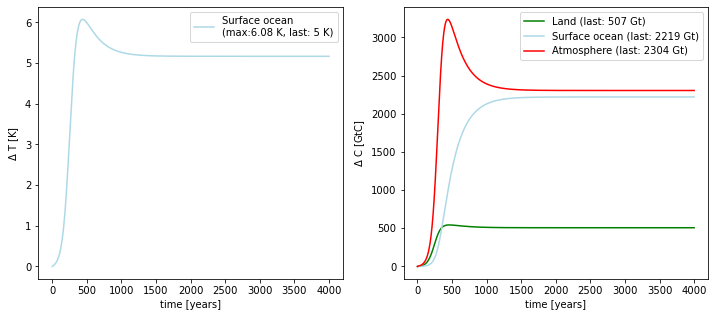

In [6]:
no_deep = BoxModel(step=(4000,1))

model = no_deep
model.add_box('surface ocean', {'C':0.0, 'T': 0.0, 'c': constants[delta] * constants[c_star]})
print(f"capacity of surface ocean: {model.boxes['surface ocean'].get('c')}\n")
model.add_box('atmosphere',    {'C':0.0} )
model.add_box('land', {'C':0.0 } )

model.boxes['surface ocean'].add_process('radiation', 'T', radiation_term_no_deep(), 
                                           [ model.ref('surface ocean_T'), 
                                             # only_ocean.ref('deep ocean_T'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_c')
                                           ])
model.boxes['surface ocean'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='-')
model.boxes['atmosphere'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='-')
model.boxes['land'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('emission', 'C', anthropogenic_emission(), 
                                           [ model.current_time,
                                           ], sign='+')
model.run()
fig, axs = maria_plot(model)

Most of our assumptions turned out to be right. With the exception that land biosphere did not live up to its expectations. It stores relatively less carbon than in the original model. This is likely an effect of increased surface ocean temperature, which in turn affects carbon decay ratios and release to the atmosphere ( $ \tau_l^0  \chi^( \frac{-T_s}{10}  $).

## Equilibration times

Another striking feature is that the model seems to equilibrate much faster. This could have two reasons. When we cut off the deep ocean we actually are modifying the system in two ways: Removing a barrier in the reservoir and reducing its size. 
The size ratios of surface and deep ocean are hidden in its capacities, which are calculated based on a *surface ocean fraction* $\delta$ (= 0.15). The So just removing the deep ocean without further changes will 85 % of the oceans heat capacity. The deep ocean also is different from the surface ocean in the sense that is does not communicate with the atmosphere directly. It is a hidden layer and its exchange functions ($ \eta_H  (T_s - T_d)$ and $\eta_C  ( C_s - C_d )$) introduce a certain sluggishness to the system.
To make sure we are not analysing mixed effects we will increase the surface oceans size by adapting $\delta$.

capacity of surface ocean: 342.4657534246575

dict_keys(['step', 'time', 'surface ocean_C', 'surface ocean_T', 'surface ocean_c', 'atmosphere_C', 'land_C'])


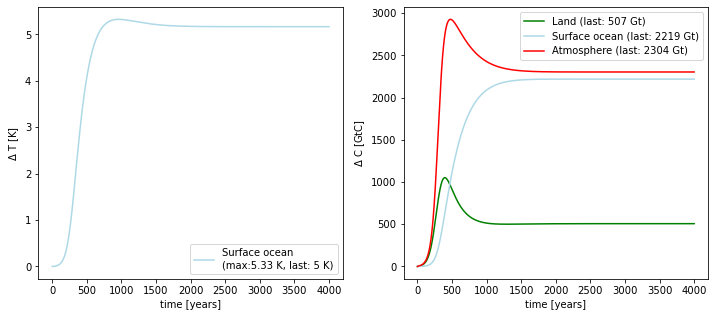

In [7]:
big_surface_ocean = BoxModel(step=(4000,1))
model = big_surface_ocean

# set surface ocean fraction to 1
model.add_box('surface ocean', {'C':0.0, 'T': 0.0, 'c': 1 * constants[c_star]})
print(f"capacity of surface ocean: {model.boxes['surface ocean'].get('c')}\n")
model.add_box('atmosphere',    {'C':0.0} )
model.add_box('land', {'C':0.0 } )

model.boxes['surface ocean'].add_process('radiation', 'T', radiation_term_no_deep(), 
                                           [ model.ref('surface ocean_T'), 
                                             # only_ocean.ref('deep ocean_T'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_c')
                                           ])
model.boxes['surface ocean'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='-')
model.boxes['atmosphere'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='-')
model.boxes['land'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('emission', 'C', anthropogenic_emission(), 
                                           [ model.current_time,
                                           ], sign='+') 
model.run()
fig, axs = maria_plot(model)

This does look slightly different than our previous version which didn't correct for the reservoir size. The bigger heat capacity now is able to buffer the heating by the atmospheres rising carbon concentrations better. This in turn results in an increase in land carbon. Land carbon is linked to surface temperatures and with rising temperatures land will not be able to absorb as much carbon, because the decay term ($ \frac{C_l + C_l^0}{(\tau_l^0  \chi^( \frac{-T_s}{10}} $) dominates over the accumulation term ($ \Pi^0  \big[ (1 + \beta_\Pi  ln \big( \frac{C_a}{C_a^0} + 1 \big) \big]  $). Atmospheric carbon shows a less prominent, because it is dampened by the lands response.

## More perturbations

We want to explore the longer equilibration times further, thus we will add another perturbance. After we wait for the model to reach a stable equilibrium we will remove the CO$_2$ we added in the first place. To achieve this we will use the same emission function, flip it and reverse it. The original function is defined as the derivative of the function:

In [8]:
t = sym.Symbol('t')
cons = fetch_constants([A_tot, t_opt])

expr = A_tot * ((1 / (1 + 2.5 * sym.exp((t_opt - t)/50))) - (1 / (1 + 2.5 * sym.exp(t_opt / 50))))
expr_dt = sym.Derivative(expr,t).doit()
expr

A_{tot}*(1/(2.5*exp(-t/50 + t_{opt}/50) + 1) - 1/(2.5*exp(t_{opt}/50) + 1))

The resulting function looks like this:

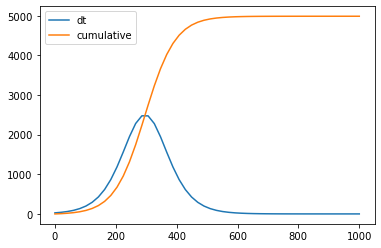

In [9]:
emi_dt = sym.lambdify((t), expr_dt.subs(cons))
emi_int = sym.lambdify((t), expr.subs(cons))

x  = np.linspace(0,1000)
y1 = emi_dt(x)
y2 = emi_int(x)

plt.plot(x,y1 * 100,label='dt')
plt.plot(x,y2,label='cumulative')
plt.legend()

By modifying the parameters we clearly see how they influence the shape of the emission function. Negative emissions are achieved by changing the sign of $A_{tot}$, a later beginning of the emissions is achieved by modifying $t_{opt}$.

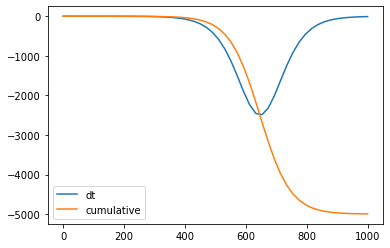

In [10]:
cons_negative = {
    A_tot : -5000,
    t_opt : 600
}

emi_dt = sym.lambdify((t), expr_dt.subs(cons_negative))
emi_int = sym.lambdify((t), expr.subs(cons_negative))

x  = np.linspace(0,1000)
y1 = emi_dt(x)
y2 = emi_int(x)

plt.plot(x,y1 * 100,label='dt') # * 100 for visibility reasons
plt.plot(x,y2,label='cumulative')
plt.legend()

The shape can also be influenced, introducing a new variable to the emission function. 

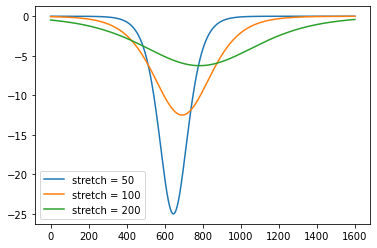

In [11]:
stretch = sym.Symbol('S')

expr = A_tot * ((1 / (1 + 2.5 * sym.exp((t_opt - t)/stretch))) - (1 / (1 + 2.5 * sym.exp(t_opt / stretch))))
expr_dt = sym.Derivative(expr,t).doit()

emission = sym.lambdify((t, stretch), expr_dt.subs(cons_negative))

x  = np.linspace(0,1600,16000)

for stretch in [50,100,200]:
    plt.plot(x, emission(x,stretch),label=f'stretch = {stretch}')
plt.legend()

Now we add our new emission function to the model. We choose $t_{opt} = 7500$ to give the model enough time to equilibrate and to visually separate the two perturbations. We have to run the model for longer to see the results.

In [128]:
def emission_function(A_tot=5000, t_opt=250, stretch=50):
    # above emission function in a more flexible definition
    # used for negative emissions and emissions over larger time frame
    t = sym.Symbol('t')
    expr = A_tot * ((1 / (1 + 2.5 * sym.exp((t_opt - t)/stretch))) - (1 / (1 + 2.5 * sym.exp(t_opt / stretch))))
    expr_dt = sym.Derivative(expr,t).doit()
    return sym.lambdify((t), expr_dt.subs(constants))

dict_keys(['step', 'time', 'deep ocean_C', 'deep ocean_T', 'deep ocean_c', 'surface ocean_C', 'surface ocean_T', 'surface ocean_c', 'atmosphere_C', 'land_C'])


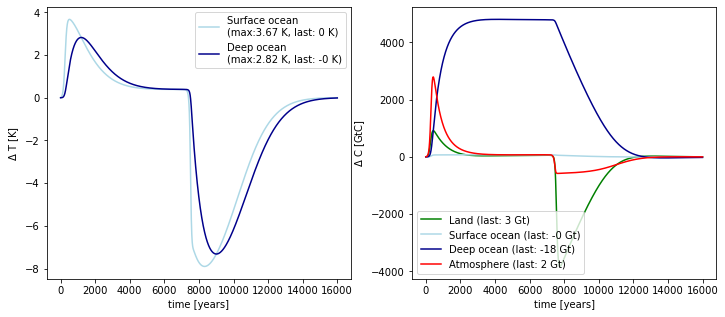

In [155]:
coupled_longrun = BoxModel(step=(16000,1))
model = coupled_longrun
model.add_box('deep ocean',    {'C':0.0, 'T': 0.0, 'c':(1 - constants[delta]) * constants[c_star]})
model.add_box('surface ocean', {'C':0.0, 'T': 0.0, 'c':constants[delta]      * constants[c_star]})
model.add_box('atmosphere',    {'C':0.0} )
model.add_box('land', {'C':0.0 } )

model.boxes['deep ocean'].add_process('ocean circulation', 'T', enthalpy_exchange(), 
                                           [ model.boxes['surface ocean'].attr['T'], 
                                             model.boxes['deep ocean'].attr['T'],
                                             model.boxes['deep ocean'].attr['c']
                                           ], sign='+')
model.boxes['surface ocean'].add_process('ocean circulation', 'T', enthalpy_exchange(), 
                                           [ model.boxes['surface ocean'].attr['T'], 
                                             model.boxes['deep ocean'].attr['T'],
                                             model.boxes['surface ocean'].attr['c']
                                           ], sign='-')
model.boxes['deep ocean'].add_process('carbon flux', 'C', carbon_flux_surface_deep(), 
                                           [ model.ref('surface ocean_C'),
                                             model.ref('deep ocean_C')
                                           ], sign='+')
model.boxes['surface ocean'].add_process('carbon flux', 'C', carbon_flux_surface_deep(), 
                                           [ model.ref('surface ocean_C'),
                                             model.ref('deep ocean_C')
                                           ], sign='-')
model.boxes['surface ocean'].add_process('radiation', 'T', radiation_term(), 
                                           [ model.ref('surface ocean_T'), 
                                             model.ref('deep ocean_T'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_c')
                                           ])
model.boxes['surface ocean'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='-')
model.boxes['atmosphere'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='-')
model.boxes['land'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('emission', 'C', emission_function(5000,250,50), 
                                           [ model.current_time,
                                           ], sign='+') 
model.boxes['atmosphere'].add_process('negative_emission', 'C', emission_function(-5000,7500,50), 
                                           [ model.current_time,
                                           ], sign='+')
model.run()
maria_plot(model, full=True)
plt.show()

To our suprise the response to carbon removal is very different to the response to carbon input. One of the most prominent features is the assymetry in the ocean temperature response with almost double the amplitude in the emission removal transient response. 

## Limits of carbon removal

There seems to be no upper limit in the amount of $CO_2$ the atmosphere can take up. The lower limit on the other hand is a true zero, which in our model is equivalent to:
$$
- C_a^0 = k_a \cdot preIndustrial CO_2 = 2.12 \cdot 280 = -593.6
$$
The model is working really hard to replenish the Atmospheres $CO_2$ levels. Increasing the peak in $CO_2$ removal by negative emission a little more actually pushes the model to the brink of instability and can cause it to crash if the timestep is not small enough and the atmospheric $CO_2$ actually drops below -593.6:

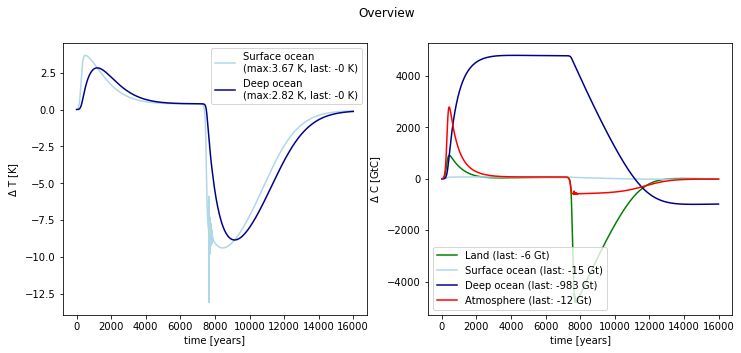

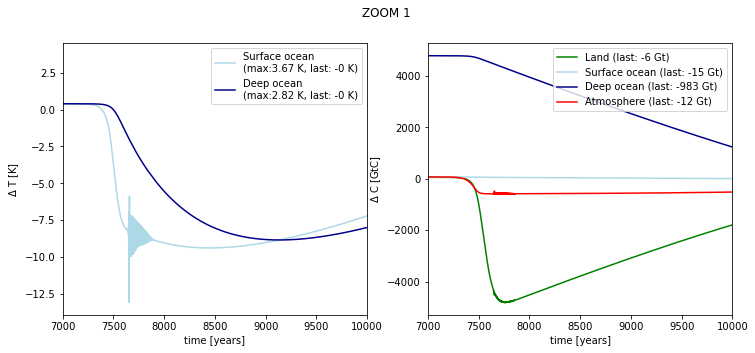

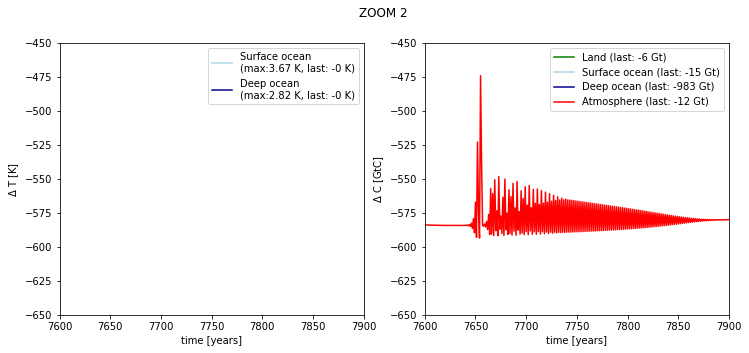

In [181]:
unstable = BoxModel(step=(16000,1))
model = unstable
model.add_box('deep ocean',    {'C':0.0, 'T': 0.0, 'c':(1 - constants[delta]) * constants[c_star]})
model.add_box('surface ocean', {'C':0.0, 'T': 0.0, 'c':constants[delta]      * constants[c_star]})
model.add_box('atmosphere',    {'C':0.0} )
model.add_box('land', {'C':0.0 } )

model.boxes['deep ocean'].add_process('ocean circulation', 'T', enthalpy_exchange(), 
                                           [ model.boxes['surface ocean'].attr['T'], 
                                             model.boxes['deep ocean'].attr['T'],
                                             model.boxes['deep ocean'].attr['c']
                                           ], sign='+')
model.boxes['surface ocean'].add_process('ocean circulation', 'T', enthalpy_exchange(), 
                                           [ model.boxes['surface ocean'].attr['T'], 
                                             model.boxes['deep ocean'].attr['T'],
                                             model.boxes['surface ocean'].attr['c']
                                           ], sign='-')
model.boxes['deep ocean'].add_process('carbon flux', 'C', carbon_flux_surface_deep(), 
                                           [ model.ref('surface ocean_C'),
                                             model.ref('deep ocean_C')
                                           ], sign='+')
model.boxes['surface ocean'].add_process('carbon flux', 'C', carbon_flux_surface_deep(), 
                                           [ model.ref('surface ocean_C'),
                                             model.ref('deep ocean_C')
                                           ], sign='-')
model.boxes['surface ocean'].add_process('radiation', 'T', radiation_term(), 
                                           [ model.ref('surface ocean_T'), 
                                             model.ref('deep ocean_T'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_c')
                                           ])
model.boxes['surface ocean'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='-')
model.boxes['atmosphere'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='-')
model.boxes['land'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('emission', 'C', emission_function(5000,250,50), 
                                           [ model.current_time,
                                           ], sign='+') 
model.boxes['atmosphere'].add_process('negative_emission', 'C', emission_function(-6000,7500,50), 
                                           [ model.current_time,
                                           ], sign='+')
model.run()
maria_plot(model, full=True, title='Overview')
maria_plot(model, full=True, title='ZOOM 1',xlim=(7000,10000))
maria_plot(model, full=True, title='ZOOM 2', xlim=(7600,7900), ylim=(-650,-450))

plt.show()

## What was the deep oceans role agNow we want to have a look at the response of a model with no separate deep ocean (but equal overall ocean size) to the negative forcing.

capacity of surface ocean: 342.4657534246575

dict_keys(['step', 'time', 'surface ocean_C', 'surface ocean_T', 'surface ocean_c', 'atmosphere_C', 'land_C'])


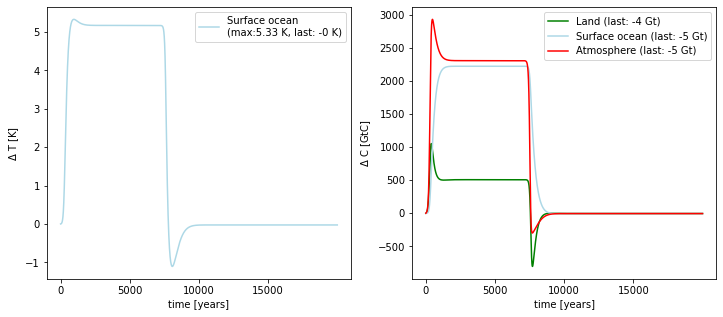

In [163]:
noocean_longrun = BoxModel(step=(20000,1))

model = noocean_longrun
model.add_box('surface ocean', {'C':0.0, 'T': 0.0, 'c': 1 * constants[c_star]})
print(f"capacity of surface ocean: {model.boxes['surface ocean'].get('c')}\n")
model.add_box('atmosphere',    {'C':0.0} )
model.add_box('land', {'C':0.0 } )

model.boxes['surface ocean'].add_process('radiation', 'T', radiation_term_no_deep(), 
                                           [ model.ref('surface ocean_T'), 
                                             # only_ocean.ref('deep ocean_T'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_c')
                                           ])
model.boxes['surface ocean'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('atmos_ocean_exchange', 'C', atmosphere_ocean_exchange(), 
                                           [ model.ref('atmosphere_C'),
                                             model.ref('surface ocean_C')
                                           ], sign='-')
model.boxes['atmosphere'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='-')
model.boxes['land'].add_process('land_atmos_exchange', 'C', land_carbon_uptake(), 
                                           [ model.ref('land_C'),
                                             model.ref('atmosphere_C'),
                                             model.ref('surface ocean_T')
                                           ], sign='+')
model.boxes['atmosphere'].add_process('emission', 'C', emission_function(5000,250,50), 
                                           [ model.current_time,
                                           ], sign='+') 
model.boxes['atmosphere'].add_process('negative_emission', 'C', emission_function(-5000,7500,50), 
                                           [ model.current_time,
                                           ], sign='+')
model.run()
fig, axs = maria_plot(model)
for ax in axs:
    ax.set_xticks([0,5000,10000,15000])
plt.show()

The reduced model does show a less pronounced assymetry in the transient response to the two different perturbations. For both perturbations the time until a new equilibrium is reached is much shorter, than in the full model. 

dict_keys(['step', 'time', 'deep ocean_C', 'deep ocean_T', 'deep ocean_c', 'surface ocean_C', 'surface ocean_T', 'surface ocean_c', 'atmosphere_C', 'land_C'])


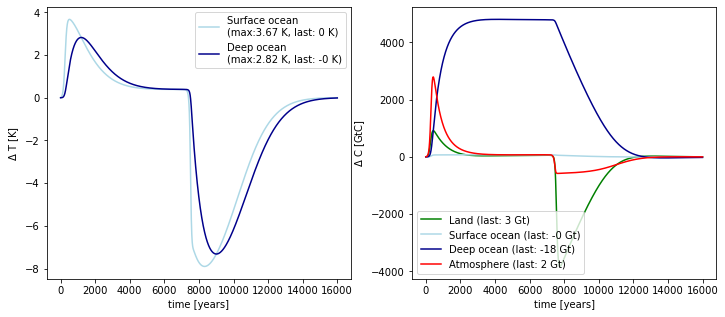

In [156]:
maria_plot(coupled_longrun, full=True)
plt.show()

The assymetry is probably caused by the different ocean temperatures in the two equilibrium states. This causes the land carbon storage, which is dependent on temperature, to act differently. In the two layer ocean, this temperature difference can be maintained for longer, and thus the land can be held in an extreme state for longer.

Next we want to actually measure the time scales of transients. To achieve this we:
 1. compute the first order differential
 2. identify zones of non-zero differential. 
    (this shows where the model is still adjusting.)
    Rather than to zero, we compare to a threshold
 3. we take the outer edges of all threshold crossings

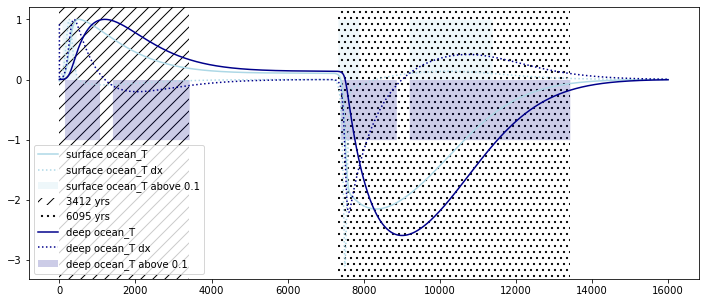

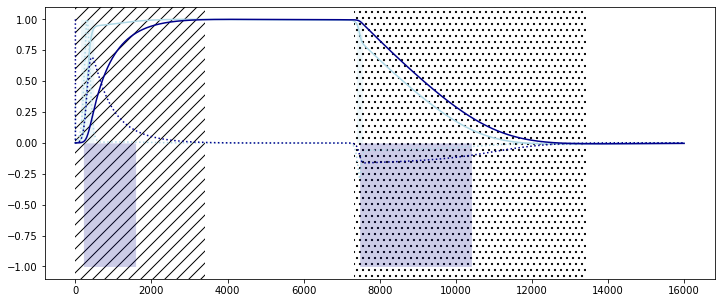

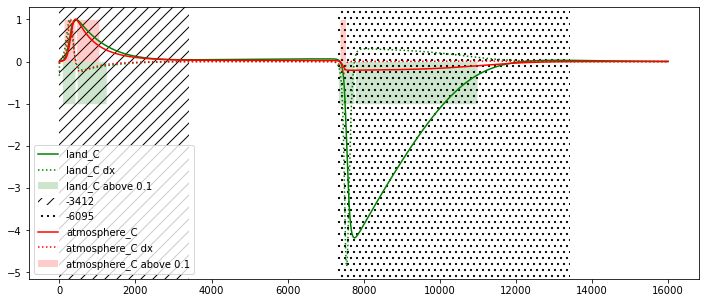

In [173]:
model = coupled_longrun

gooddata = model.output.copy()
# discard quantities that have been saved automatically, but hold no information.
for boring in ['step', 'time', 'deep ocean_c', 'surface ocean_c']: 
    del(gooddata[boring])

# 1: deltas
dy = dict()
for key, value in gooddata.items():
    dx = list(range(len(value)-1))
    dy[key] = list()
    for i, e in enumerate(value[1::]):
        dy[key].append((e - value[i-1]) )

# 2: above threshold:
threshold = 0.1
change = dict()
for key, val in dy.items():
    change[key] = (np.abs(val) > np.max(val) * threshold)

# 3.1 edges
edges = dict()
for key, val in change.items():
    edges[key] = []
    for i, e in enumerate(val):
        if e != val[i-1]:
            edges[key].append(i)
            
# 3.2 outer edges of each variable
sharpedges = dict()
for key, value in edges.items():
    # we cut the data set in half to separate the two perturbations
    increase = [ed for ed in value if ed < 6000] 
    decrease = [ed for ed in value if ed > 6000]
    sharpedges[key] = (min(increase),max(increase)),(min(decrease), max(decrease))

# 3.3 outer edges of all variables
outeredges = []
outeredges.append((min([e[0][0] for e in sharpedges.values()]), max([e[0][1] for e in sharpedges.values()])))
outeredges.append((min([e[1][0] for e in sharpedges.values()]), max([e[1][1] for e in sharpedges.values()])))

# plot
fig1, ax1 = plt.subplots(figsize=(12, 5))
ax = ax1
key = 'surface ocean_T'
color = 'lightblue'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
ax.fill_between(dx, 0, change[key] , color='lightblue',  label=f'{key} above {threshold}', lw=0, alpha=0.2)
ax.axvspan(*outeredges[0], fill=None, hatch='//', lw = 0, label=f"{outeredges[0][1] - outeredges[0][0]} yrs")
ax.axvspan(*outeredges[1], fill=None, hatch='..', lw = 0, label=f"{outeredges[1][1] - outeredges[1][0]} yrs")

key = 'deep ocean_T'
color = 'darkblue'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
# ax.plot(ddx, ddy[key] / np.max(np.abs(ddy[key])), color='lightblue', label=f'd Land', linestyle=':')
ax.fill_between(dx, 0, change[key] * -1, color=color,  label=f'{key} above {threshold}', lw=0, alpha=0.2)
ax.legend()

fig2, ax2 = plt.subplots(figsize=(12, 5))
ax = ax2
key = 'surface ocean_C'
color = 'lightblue'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
ax.fill_between(dx, 0, change[key] , color='lightblue',  label=f'{key} above {threshold}', lw=0, alpha=0.2)
ax.axvspan(*outeredges[0], fill=None, hatch='//', lw = 0, label=f"{outeredges[0][1] - outeredges[0][0]} yrs")
ax.axvspan(*outeredges[1], fill=None, hatch='..', lw = 0, label=f"{outeredges[1][1] - outeredges[1][0]} yrs")

key = 'deep ocean_C'
color = 'darkblue'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
# ax.plot(ddx, ddy[key] / np.max(np.abs(ddy[key])), color='lightblue', label=f'd Land', linestyle=':')
ax.fill_between(dx, 0, change[key] * -1, color=color,  label=f'{key} above {threshold}', lw=0, alpha=0.2)
# ax.legend()

fig3, ax3 = plt.subplots(figsize=(12, 5))
ax = ax3
key = 'land_C'
color = 'green'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
# ax.plot(ddx, ddy[key] / np.max(np.abs(ddy[key])), color='lightblue', label=f'd Land', linestyle=':')
ax.fill_between(dx, 0, change[key] * -1, color=color,  label=f'{key} above {threshold}', lw=0, alpha=0.2)
ax.axvspan(*outeredges[0], fill=None, hatch='//', lw = 0, label=f"{outeredges[0][0] - outeredges[0][1]}")
ax.axvspan(*outeredges[1], fill=None, hatch='..', lw = 0, label=f"{outeredges[1][0] - outeredges[1][1]}")

key = 'atmosphere_C'
color = 'red'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
# ax.plot(ddx, ddy[key] / np.max(np.abs(ddy[key])), color='lightblue', label=f'd Land', linestyle=':')
ax.fill_between(dx, 0, change[key] , color=color,  label=f'{key} above {threshold}', lw=0, alpha=0.2)
ax.legend()

plt.show()

dict_keys(['surface ocean_C', 'surface ocean_T', 'atmosphere_C', 'land_C'])


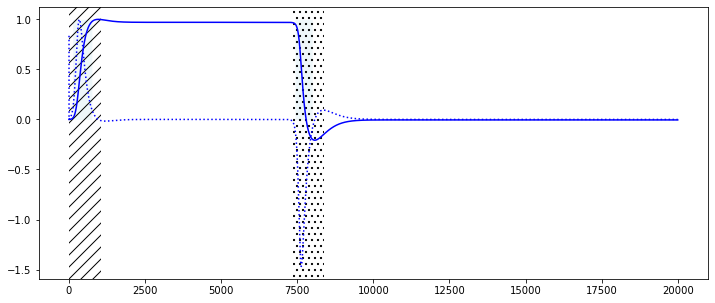

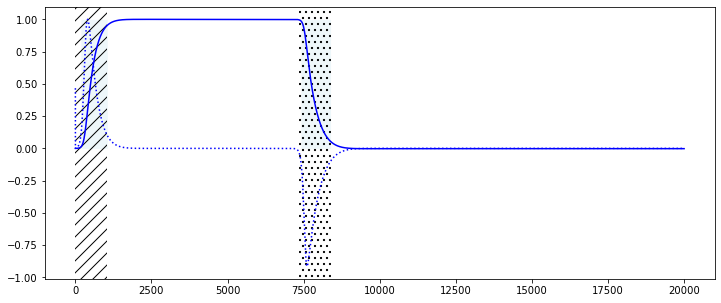

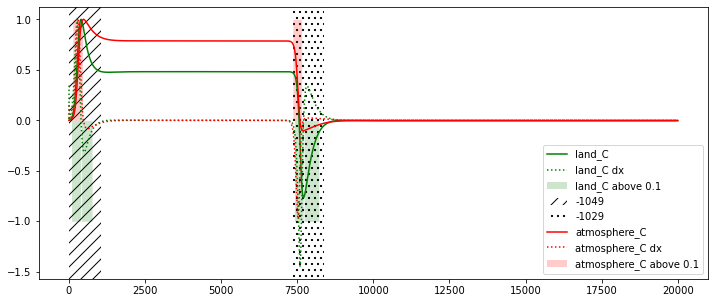

In [174]:
model = noocean_longrun

gooddata = model.output.copy()
# discard quantities that have been saved automatically, but hold no information.
for boring in ['step', 'time', 'surface ocean_c']: 
    del(gooddata[boring])
print(gooddata.keys())

# 1: deltas
dy = dict()
for key, value in gooddata.items():
    dx = list(range(len(value)-1))
    dy[key] = list()
    for i, e in enumerate(value[1::]):
        dy[key].append((e - value[i-1]) )

# 2: above threshold:
threshold = 0.01
threshold = 0.1
change = dict()
for key, val in dy.items():
    change[key] = (np.abs(val) > np.max(val) * threshold)

# 3.1 edges
edges = dict()
for key, val in change.items():
    edges[key] = []
    for i, e in enumerate(val):
        if e != val[i-1]:
            edges[key].append(i)
            
# 3.2 outer edges of each variable
sharpedges = dict()
for key, value in edges.items():
    # we cut the data set in half to separate the two perturbations
    increase = [ed for ed in value if ed < 6000] 
    decrease = [ed for ed in value if ed > 6000]
    sharpedges[key] = (min(increase),max(increase)),(min(decrease), max(decrease))

# 3.3 outer edges of all variables
outeredges = []
outeredges.append((min([e[0][0] for e in sharpedges.values()]), max([e[0][1] for e in sharpedges.values()])))
outeredges.append((min([e[1][0] for e in sharpedges.values()]), max([e[1][1] for e in sharpedges.values()])))

# plot
fig1, ax1 = plt.subplots(figsize=(12, 5))
ax = ax1
key = 'surface ocean_T'
color = 'blue'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
ax.fill_between(dx, 0, change[key] , color='lightblue',  label=f'{key} above {threshold}', lw=0, alpha=0.2)
ax.axvspan(*outeredges[0], fill=None, hatch='//', lw = 0, label=f"{outeredges[0][1] - outeredges[0][0]} yrs")
ax.axvspan(*outeredges[1], fill=None, hatch='..', lw = 0, label=f"{outeredges[1][1] - outeredges[1][0]} yrs")


fig2, ax2 = plt.subplots(figsize=(12, 5))
ax = ax2
key = 'surface ocean_C'
color = 'blue'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
ax.fill_between(dx, 0, change[key] , color='lightblue',  label=f'{key} above {threshold}', lw=0, alpha=0.2)
ax.axvspan(*outeredges[0], fill=None, hatch='//', lw = 0, label=f"{outeredges[0][1] - outeredges[0][0]} yrs")
ax.axvspan(*outeredges[1], fill=None, hatch='..', lw = 0, label=f"{outeredges[1][1] - outeredges[1][0]} yrs")


fig3, ax3 = plt.subplots(figsize=(12, 5))
ax = ax3
key = 'land_C'
color = 'green'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
# ax.plot(ddx, ddy[key] / np.max(np.abs(ddy[key])), color='lightblue', label=f'd Land', linestyle=':')
ax.fill_between(dx, 0, change[key] * -1, color=color,  label=f'{key} above {threshold}', lw=0, alpha=0.2)
ax.axvspan(*outeredges[0], fill=None, hatch='//', lw = 0, label=f"{outeredges[0][0] - outeredges[0][1]}")
ax.axvspan(*outeredges[1], fill=None, hatch='..', lw = 0, label=f"{outeredges[1][0] - outeredges[1][1]}")

key = 'atmosphere_C'
color = 'red'
ax.plot(model.output['time'], model.output[key] / np.max(model.output[key]), color=color, label=key)
ax.plot(dx, dy[key] / np.max(dy[key]), color=color, label=f"{key} dx", linestyle=':')
# ax.plot(ddx, ddy[key] / np.max(np.abs(ddy[key])), color='lightblue', label=f'd Land', linestyle=':')
ax.fill_between(dx, 0, change[key] , color=color,  label=f'{key} above {threshold}', lw=0, alpha=0.2)
ax.legend()

plt.show()

What we learned:

 * The separation of the ocean into two layers is an important constraint on the time scale of the transient state. 
 * The capacity (size) of the ocean does neither affect the time scale, nor the equilibrium state.
 * There is an assymetry in the response to perturbations, which is probably caused by the land carbon capture rate dependency on temperature.
 * Carbon can barely be removed at the same rate it was emitted into the atmosphere. The system redistributes it into reservoirs, that are much slower and thus harder to access. It then releases the accumulated carbon over a much longer time scale. 
 * This last point might have some implications when looking at negative emissions as a real application to combat climate change. In the end it is atmospheric carbon we care most about, because atmospheric carbon is the one influencing the climate. But high carbon contents in the ocean might influence primary production. In a similar manner land carbon uptake might be influenced negatively by negative emissions.
 
A note on our model:
 
We worked with two models. One uses an ODE solver, another one is an object oriented numerical solver. The technical side *should* not matter, but although we use the same equations and the same constants, both model deliver different results. This might be because they use different methods of integration (the OOP Boxmodel uses Euler, the `solve_ivp` uses a undisclosed method). In the end we did most of our plots with the OOP model, because it crashed less. This does not mean that it is a better model. Somehow the exchange rate in the OOP model were stronger, leading to e.g. a higher peak in atmospheric carbon in response to anthropogenic emissions. Also negative emissions are buffered better by the system, so that it was less likely to reach the critical value of -593.6 in response to fast negative emissions. See the following basic setup of the ODE solver model:

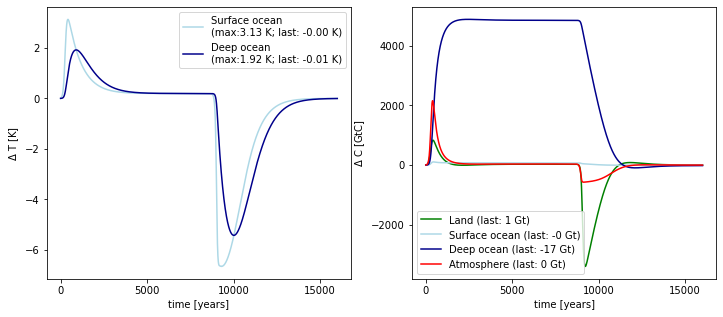

In [126]:
from scipy.integrate import solve_ivp

stretch = 50

A_tot, t_opt, t = sym.symbols('A_{tot}, t_{opt}, t')  # Symbols for the function
A_t_expr = (A_tot * ((1 / (1 + 2.5 * sym.exp((t_opt - t)/stretch))) - (1 / (1 + 2.5 * sym.exp(t_opt / stretch))))).diff(t)
J_t = sym.lambdify((A_tot, t), A_t_expr.subs({t_opt: constants[t_opt]}))
A_t_minus_expr = (-A_tot * ((1 / (1 + 2.5 * sym.exp((t_opt - t)/stretch))) - (1 / (1 + 2.5 * sym.exp(t_opt / stretch))))).diff(t)
J_t_minus = sym.lambdify((A_tot, t), A_t_minus_expr.subs({t_opt: 9000}))

# define the model
def odes_full(time, variables, constants, a_tot):
    C_l = variables[0]
    C_s = variables[1]
    C_d = variables[2]
    C_a = variables[3]
    T_s = variables[4]
    T_d = variables[5]
    
    J_t_val = J_t(a_tot, time)
    J_t_minus_val = J_t_minus(a_tot, time)
    # R_h : heterotrophic (soil) respiration (Eq. 7.5)
    R_h = (C_l + constants[C_l0])/(constants[tau_l0] * (constants[chi] ** (- T_s / 10)))
    # P: global net primary productivity
    P = constants[preInd] * (1 + constants[beta_P] * np.log(C_a/constants[C_a0] + 1))
    # Carbon concentration difference between deeper and upper ocean
    J_s_d = constants[eta_C] * (C_s / constants[delta] - C_d / (1 - constants[delta]))
    # Uptake of atmospheric carbon by the surface ocean
    J_a_s = constants[gam] * ((C_a) - (C_s / constants[k_o]))
    # System of coupled ODE's to solve the coupled model
    Ts_dot = (1 / (constants[delta] * constants[c_star])) * ( - constants[lam] * T_s + \
              constants[beta] * np.log(C_a / constants[C_a0] + 1) - constants[eta_H] * (T_s - T_d) - \
              constants[lam_st] * (T_s - T_d))
    # System of coupled ODE's to solve the carbon model
    Td_dot = constants[eta_H] * (T_s - T_d) / ((1 - constants[delta]) * constants[c_star])
    Cl_dot = P - R_h
    Cs_dot = J_a_s - J_s_d
    Cd_dot = J_s_d
    Ca_dot = J_t_val + J_t_minus_val - Cl_dot - Cs_dot - Cd_dot
    
    return [Cl_dot, Cs_dot, Cd_dot, Ca_dot, Ts_dot, Td_dot]

# Defining time vector
time_step = 1
t_last = 16000
time = np.linspace(0, t_last, int(t_last/time_step), endpoint=True)

# run the model
solution_full = solve_ivp(odes_full, (0, t_last), y0=[0, 0, 0, 0, 0, 0], method='LSODA', t_eval=time, args=(constants, 5000))

# Plot the solution to check if they are correct
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0] 
ax.plot(solution_full.t, solution_full.y[4], color='lightblue', label=f"Surface ocean \n(max:{np.max(solution_full.y[4]):.2f} K; last: {solution_full.y[4][-1]:.2f} K)")
ax.plot(solution_full.t, solution_full.y[5], color='darkblue', label=f"Deep ocean \n(max:{np.max(solution_full.y[5]):.2f} K; last: {solution_full.y[5][-1]:.2f} K)")
ax.set_xlabel('time [years]')
ax.set_ylabel('$\Delta$ T [K]')
ax.legend()
ax.set_xticks([0, 5000, 10000, 15000])
ax = axs[1]
ax.plot(solution_full.t, solution_full.y[0], color='green', label=f'Land (last: {solution_full.y[0][-1]:.0f} Gt)')
ax.plot(solution_full.t, solution_full.y[1], color='lightblue', label=f'Surface ocean (last: {solution_full.y[1][-1]:.0f} Gt)')
ax.plot(solution_full.t, solution_full.y[2], color='darkblue', label=f'Deep ocean (last: {solution_full.y[2][-1]:.0f} Gt)')
ax.plot(solution_full.t, solution_full.y[3], color='red', label=f'Atmosphere (last: {solution_full.y[3][-1]:.0f} Gt)')
ax.set_xlabel('time [years]')
ax.set_xticks([0, 5000, 10000, 15000])
ax.set_ylabel('$\Delta$ C [GtC]')
ax.legend()

plt.show()

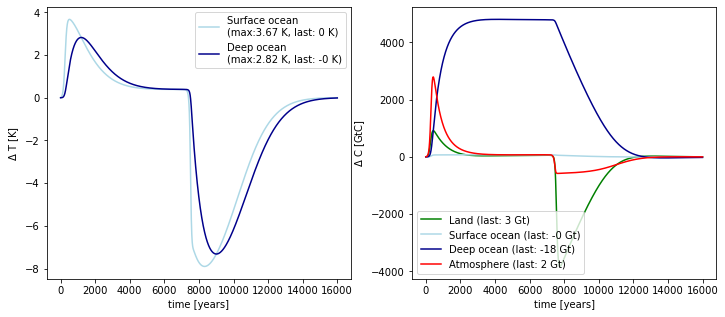

In [182]:
# again for comparison
maria_plot(coupled_longrun, full=True)
plt.show()